In [2]:
pip install nibabel matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import os
import zipfile
import nibabel as nib
import matplotlib.pyplot as plt

# **Step 1: Load Data**

In [4]:
# Define paths
data_path = '/cluster/projects/vc/data/mic/open/HNTS-MRG'
zip_file = os.path.join(data_path, 'HNTSMRG24_train.zip')

# Path to save extracted files
extracted_path = '/cluster/home/bjorneme/projects/tdt17_mini_project/TDT17_mini_project/Data'

# Create extraction directory if it doesn't exist
os.makedirs(extracted_path, exist_ok=True)

# Unzip the dataset into the specified directory
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # List all files in the ZIP archive
    all_files = zip_ref.namelist()
    
    # Filter out only the files that are inside the 'preRT/' directories
    preRT_files = [f for f in all_files if '/preRT/' in f]
    
    # Extract only the 'preRT/' files
    for file in preRT_files:
        zip_ref.extract(member=file, path=extracted_path)

print("Extraction complete.")

Extraction complete.


In [5]:
# Path to the training data
train_dir = os.path.join(extracted_path, 'HNTSMRG24_train')

# List all patient folders
patient_folders = os.listdir(train_dir)
print(f"Total patients extracted: {len(patient_folders)}")

Total patients extracted: 150


# **Step 2: Exploratory Data Analysis**

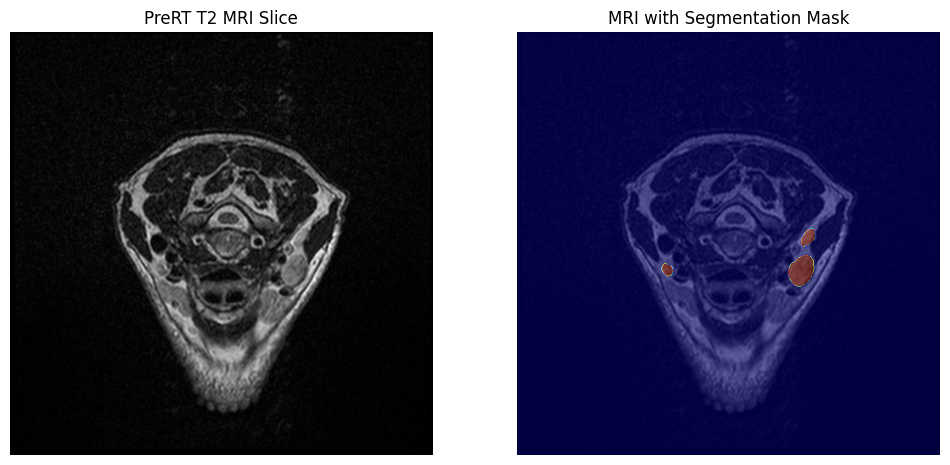

In [6]:
# Define paths
extracted_path = '/cluster/home/bjorneme/projects/tdt17_mini_project/TDT17_mini_project/Data/'
patient_id = '2'  # Example patient ID
preRT_T2_path = os.path.join(extracted_path, 'HNTSMRG24_train', patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
preRT_mask_path = os.path.join(extracted_path, 'HNTSMRG24_train', patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')

# Load MRI and Mask using Nibabel
mri_img = nib.load(preRT_T2_path)
mask_img = nib.load(preRT_mask_path)

mri_data = mri_img.get_fdata()
mask_data = mask_img.get_fdata()

# Select a slice to visualize
slice_idx = mri_data.shape[2] // 2  # Middle slice

mri_slice = mri_data[:, :, slice_idx]
mask_slice = mask_data[:, :, slice_idx]

# Plot MRI and Mask
plt.figure(figsize=(12, 6))

# MRI Image
plt.subplot(1, 2, 1)
plt.imshow(mri_slice.T, cmap='gray', origin='lower')
plt.title('PreRT T2 MRI Slice')
plt.axis('off')

# Mask Overlay
plt.subplot(1, 2, 2)
plt.imshow(mri_slice.T, cmap='gray', origin='lower')
plt.imshow(mask_slice.T, cmap='jet', alpha=0.5, origin='lower')  # Overlay mask with transparency
plt.title('MRI with Segmentation Mask')
plt.axis('off')

plt.show()

# **Step 3: Data Preprocessing**

In [7]:
# Step 3: Data Preprocessing
from sklearn.model_selection import train_test_split
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd,
    ScaleIntensityRanged, CropForegroundd, RandCropByPosNegLabeld,
    EnsureTyped, RandFlipd, RandRotate90d
)
from monai.data import CacheDataset, DataLoader
from monai.utils import set_determinism

set_determinism(seed=0)

# Prepare data dictionaries
def get_data_dicts(patient_folders, data_dir):
    data_dicts = []
    for patient_id in patient_folders:
        mri_path = os.path.join(data_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
        mask_path = os.path.join(data_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
        data_dicts.append({"image": mri_path, "label": mask_path})
    return data_dicts

data_dir = os.path.join(extracted_path, 'HNTSMRG24_train')
data_dicts = get_data_dicts(patient_folders, data_dir)

# Split data into training and validation sets
train_files, val_files = train_test_split(data_dicts, test_size=0.2, random_state=42)
print(f'Training samples: {len(train_files)}, Validation samples: {len(val_files)}')

# Define transforms for training and validation
train_transforms = Compose([
    LoadImaged(keys=['image', 'label']),
    EnsureChannelFirstd(keys=['image', 'label']),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.5, 1.5, 2.0),
        mode=("bilinear", "nearest")
    ),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-57,
        a_max=164,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    RandCropByPosNegLabeld(
        keys=["image", "label"],
        label_key="label",
        spatial_size=(96, 96, 64),  # Adjusted spatial_size
        pos=1,
        neg=1,
        num_samples=4,
        image_key="image",
        image_threshold=0,
        allow_smaller=True,  # Ensure this is set to True
    ),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=[0]),
    RandRotate90d(keys=["image", "label"], prob=0.5, max_k=3),
    EnsureTyped(keys=["image", "label"]),
])

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.5, 1.5, 2.0),
        mode=("bilinear", "nearest")
    ),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-57,
        a_max=164,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    EnsureTyped(keys=["image", "label"]),
])

# Create datasets and dataloaders
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)


/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


Training samples: 120, Validation samples: 30


Loading dataset: 100%|██████████| 120/120 [03:08<00:00,  1.57s/it]
/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loading dataset: 100%|██████████| 30/30 [00:53<00:00,  1.78s/it]


image shape: torch.Size([171, 171, 65]), label shape: torch.Size([171, 171, 65])


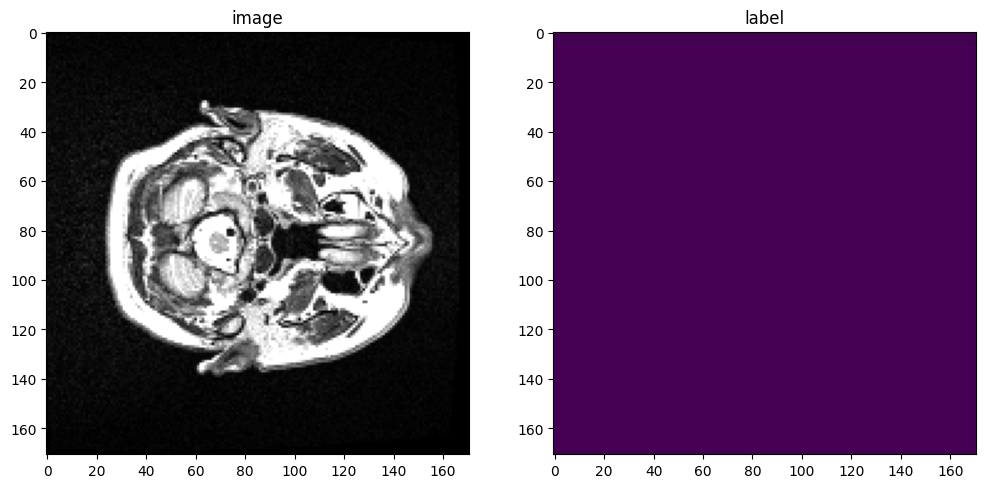

In [8]:
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.utils import first

check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 64], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 64])
plt.show()

# **Step 4: Build Model**

In [9]:
import torch
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,  # Background, GTVp, GTVn
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm='batch',
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# **Step 5: Train Model**

In [11]:
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)

max_epochs = 5
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/5


> collate dict key "image" out of 4 keys
>> collate/stack a list of tensors
>> E: stack expects each tensor to be equal size, but got [1, 96, 96, 64] at entry 0 and [1, 96, 96, 60] at entry 4, shape [torch.Size([1, 96, 96, 64]), torch.Size([1, 96, 96, 64]), torch.Size([1, 96, 96, 64]), torch.Size([1, 96, 96, 64]), torch.Size([1, 96, 96, 60]), torch.Size([1, 96, 96, 60]), torch.Size([1, 96, 96, 60]), torch.Size([1, 96, 96, 60])] in collate([metatensor([[[[0.5973, 0.4661, 0.4163,  ..., 0.4480, 0.8100, 0.8009],
          [0.3213, 0.4842, 0.5158,  ..., 0.6923, 0.8235, 0.5928],
          [0.5882, 0.5430, 0.5385,  ..., 0.8054, 0.6018, 0.4525],
          ...,
          [0.3439, 0.3077, 0.3032,  ..., 0.3032, 0.2760, 0.2805],
          [0.2805, 0.3032, 0.2805,  ..., 0.2851, 0.2670, 0.2760],
          [0.2670, 0.2805, 0.2624,  ..., 0.2715, 0.2670, 0.2805]],

         [[0.5339, 0.5475, 0.6018,  ..., 0.3756, 0.6471, 0.7059],
          [0.4842, 0.4887, 0.4072,  ..., 0.6109, 0.6833, 0.6471],
       

1/60, train_loss: 0.8280
2/60, train_loss: 0.8316
3/60, train_loss: 0.8245
4/60, train_loss: 0.8279
5/60, train_loss: 0.8221
6/60, train_loss: 0.8234
7/60, train_loss: 0.8186
8/60, train_loss: 0.8225


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/monai/data/utils.py", line 519, in list_data_collate
    ret = collate_fn(data)
          ^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 317, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    clone.update({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 155, in <dictcomp>
    clone.update({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 142, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/monai/data/utils.py", line 456, in collate_meta_tensor_fn
    collated = collate_tensor_fn(batch)
               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 213, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/monai/data/meta_tensor.py", line 282, in __torch_function__
    ret = super().__torch_function__(func, types, args, kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/_tensor.py", line 1437, in __torch_function__
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Trying to resize storage that is not resizable

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/monai/data/utils.py", line 532, in list_data_collate
    raise RuntimeError(re_str) from re
RuntimeError: Trying to resize storage that is not resizable


# **Step 6: Evaluate Model**

In [ ]:
# TODO